In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
df = pd.read_csv('tidy.csv')
df.loc[df['eventType'] == 1, 'eventType'] = 'Goal'
df.loc[df['eventType'] == 0, 'eventType'] = 'Shot'

#The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season)
df['season'] = df['gameId'].apply(lambda x: int(str(x)[:4]))

#Removing Rows with Na values
df.dropna(subset=['eventSide'],  inplace=True)
df.dropna(subset=['coordinateX'],  inplace=True)
df.dropna(subset=['coordinateY'],  inplace=True)
df.dropna(subset=['shotType'],  inplace=True)
#print(df.isna().sum())
df = df.reset_index()
#df

In [3]:
#flipping the coordinates
df['new_xcoord'] = np.where(df['eventSide'] == 'left', df['coordinateX'], (-1) * df['coordinateX'])
df['new_ycoord'] = np.where(df['eventSide'] == 'left', df['coordinateY'], (-1) * df['coordinateY'])

In [4]:
def compute_distance(x1,y1):
    x0 = 89
    y0 = 0
    distance = np.sqrt((x1-x0)**2 + (y1-y0)**2)
    return distance
df['distance'] = df.apply(lambda x: compute_distance(x['new_xcoord'], x['new_ycoord']), axis = 1 )

df['distance_round'] = df['distance'].round()
df.head()
df

,index,gameId,teamHome,teamAway,eventType,eventTeam,period,periodTime,eventSide,coordinateX,...,shooterName,goalieName,shotType,emptyNet,strength,season,new_xcoord,new_ycoord,distance,distance_round
0,0,2016020001,Ottawa Senators,Toronto Maple Leafs,Shot,Toronto Maple Leafs,1,01:11,right,-77.0,...,Mitchell Marner,Craig Anderson,Wrist Shot,NaN,NaN,2016,77.0,-5.0,13.000000,13.0
1,1,2016020001,Ottawa Senators,Toronto Maple Leafs,Shot,Ottawa Senators,1,02:53,left,86.0,...,Chris Kelly,Frederik Andersen,Wrist Shot,NaN,NaN,2016,86.0,13.0,13.341664,13.0
2,2,2016020001,Ottawa Senators,Toronto Maple Leafs,Shot,Ottawa Senators,1,04:01,left,23.0,...,Cody Ceci,Frederik Andersen,Wrist Shot,NaN,NaN,2016,23.0,-38.0,76.157731,76.0
3,3,2016020001,Ottawa Senators,Toronto Maple Leafs,Shot,Ottawa Senators,1,04:46,left,33.0,...,Erik Karlsson,Frederik Andersen,Slap Shot,NaN,NaN,2016,33.0,-15.0,57.974132,58.0
4,4,2016020001,Ottawa Senators,Toronto Maple Leafs,Shot,Toronto Maple Leafs,1,06:46,right,-34.0,...,Martin Marincin,Craig Anderson,Wrist Shot,NaN,NaN,2016,34.0,-28.0,61.717096,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376362,387824,2020030415,Tampa Bay Lightning,Montréal Canadiens,Shot,Tampa Bay Lightning,3,16:19,left,57.0,...,Blake Coleman,Carey Price,Wrist Shot,NaN,NaN,2020,57.0,30.0,43.863424,44.0
376363,387825,2020030415,Tampa Bay Lightning,Montréal Canadiens,Shot,Tampa Bay Lightning,3,17:13,left,56.0,...,Mikhail Sergachev,Carey Price,Backhand,NaN,NaN,2020,56.0,-31.0,45.276926,45.0
376364,387826,2020030415,Tampa Bay Lightning,Montréal Canadiens,Shot,Montréal Canadiens,3,19:01,right,-45.0,...,Tyler Toffoli,Andrei Vasilevskiy,Wrist Shot,NaN,NaN,2020,45.0,14.0,46.173586,46.0
376365,387827,2020030415,Tampa Bay Lightning,Montréal Canadiens,Shot,Montréal Canadiens,3,19:10,right,-77.0,...,Cole Caufield,Andrei Vasilevskiy,Backhand,NaN,NaN,2020,77.0,3.0,12.369317,12.0


## Shot Types over all teams in  a season

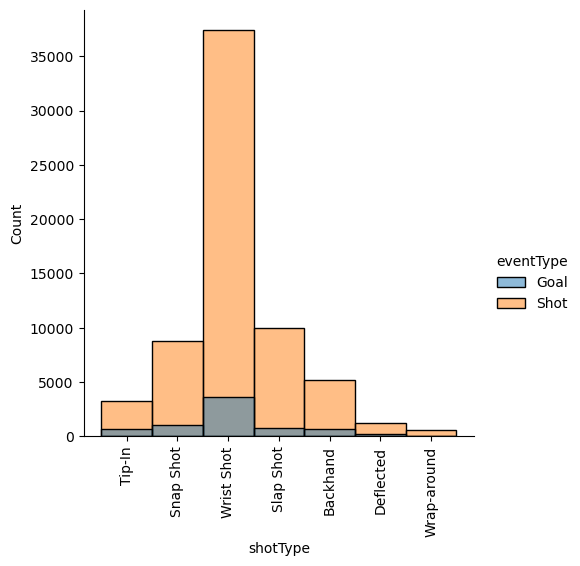

In [5]:
def shot_types_season(season):
    df_season = df[df['season'] == season].reset_index()
    ax = sns.displot(data=df_season, x = 'shotType', hue='eventType', multiple='layer')
    plt.xticks(rotation = 'vertical')
    
shot_types_season(2019)

## Relationship between the distance a shot was taken and the chance it was a goal

In [6]:
goal_percentage = df[df['eventType'] == 'Goal']['shotType'].value_counts() / df['shotType'].value_counts()
print(goal_percentage)

Backhand       0.115254
Deflected      0.169060
Slap Shot      0.064593
Snap Shot      0.098143
Tip-In         0.173147
Wrap-around    0.073125
Wrist Shot     0.090249
Name: shotType, dtype: float64


In [7]:
def distance_vs_goal_percent(season):
    df_season = df[df['season'] == season].reset_index()
    df_goals_only = df_season[df_season['eventType'] == 'Goal']
    goal_score_percent_by_dist = (df_goals_only.groupby(['distance_round'])['eventType'].count() / 
        df_season.groupby(['distance_round'])['eventType'].count() ) * 100
    
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename_axis('Distance (ft)')
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename('Goal Percentage')
    sns.scatterplot(x=goal_score_percent_by_dist.index, y=goal_score_percent_by_dist)
    plt.title(f'Goal Percentage vs Distance from Net (ft) for {season}')
    return None


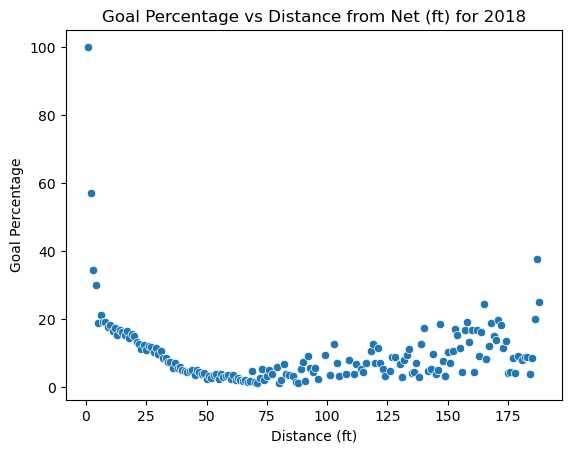

In [8]:
df_goals_only = distance_vs_goal_percent(2018)

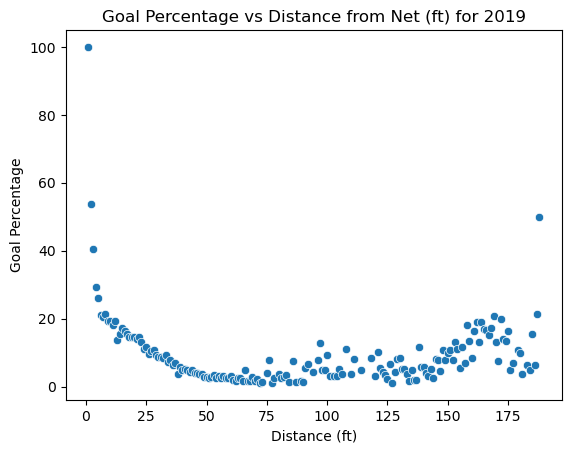

In [9]:
df_goals_only = distance_vs_goal_percent(2019)

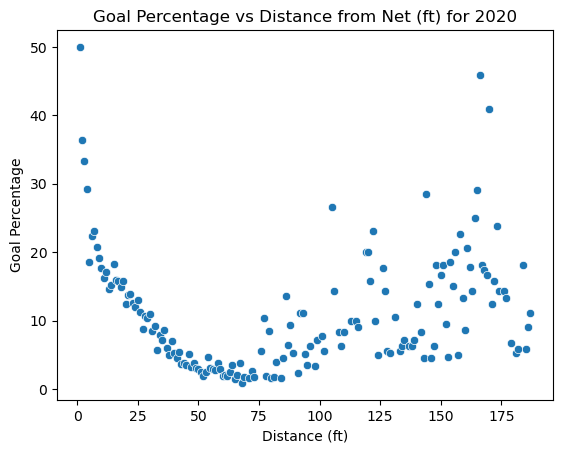

In [10]:
df_goals_only = distance_vs_goal_percent(2020)

## Goal % as a function of both distance from the net, and the category of shot types

In [11]:
def distance_vs_goal_percent_vs_shot_types(season):
    df_season = df[df['season'] == season].reset_index()
    df_goals_only = df_season[df_season['eventType'] == 'Goal']
    
    goal_score_percent_by_distance = (df_goals_only.groupby(['distance_round', 'shotType'])['eventType'].count() / 
        df_season.groupby(['distance_round', 'shotType'])['eventType'].count() ) * 100
    goal_score_percent_by_distance = goal_score_percent_by_distance.reset_index().dropna()
    goal_score_percent_by_distance = goal_score_percent_by_distance.rename(columns={'eventType': 'Goal Percentage',
                                                                                    'distance_round': 'Distance (ft)',
                                                                                    'shotType': 'Shot Type'})
    
    plt.figure(figsize=(30,12))
    plt.rcParams["axes.labelsize"] = 18    
    plt.rcParams.update({'font.size': 18})
    ax = sns.relplot(
        x=goal_score_percent_by_distance['Distance (ft)'], 
        y=goal_score_percent_by_distance['Goal Percentage'], 
        col=goal_score_percent_by_distance['Shot Type'],
        col_wrap=3,
    )
    plt.suptitle(f'Goal Percent (shots/goals) vs Distance (ft) by Shot Type', fontsize=16)
    ax.fig.subplots_adjust( top = 0.9 )

    return None


<Figure size 3000x1200 with 0 Axes>

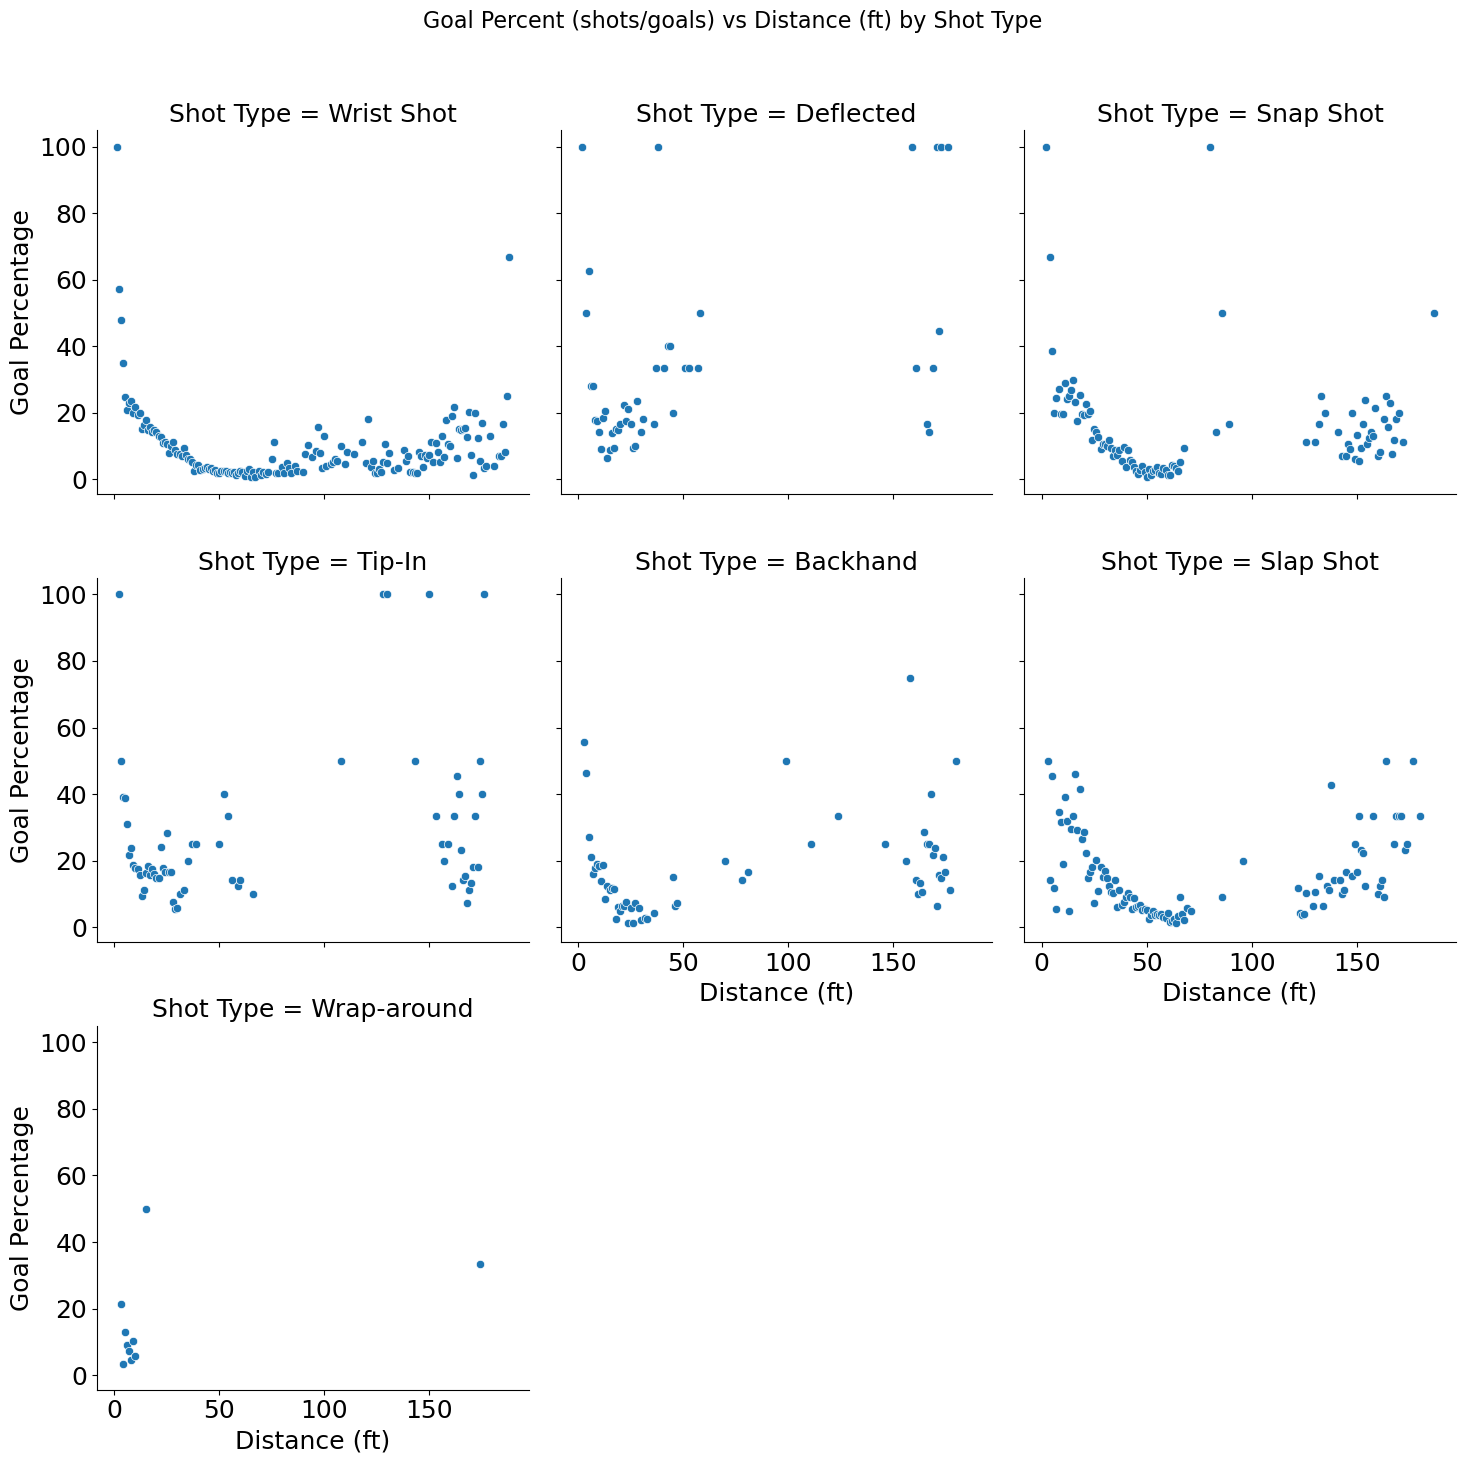

In [12]:
distance_vs_goal_percent_vs_shot_types(2019)

In [13]:
def distance_vs_goal_percent_vs_shot_types_kdeplot(season):
    df_season = df[df['season'] == season].reset_index()
    df_goals_only = df_season[df_season['eventType'] == 'Goal']
    
    goal_score_percent_by_distance = (df_goals_only.groupby(['distance', 'shotType'])['eventType'].count() / 
        df_season.groupby(['distance', 'shotType'])['eventType'].count() ) * 100
    goal_score_percent_by_distance = goal_score_percent_by_distance.reset_index().dropna()
    goal_score_percent_by_distance = goal_score_percent_by_distance.rename(columns={'eventType': 'Goal Percentage',
                                                                                    'distance': 'Distance (ft)',
                                                                                    'shotType': 'Shot Type'})
    
    shot_types = goal_score_percent_by_distance['Shot Type'].unique()
    fig, axs = plt.subplots(3,3, figsize=(20, 15), constrained_layout=True)
    plt.axis('on')
    
    for i, shot in enumerate(shot_types):
        subset = goal_score_percent_by_distance[goal_score_percent_by_distance['Shot Type'] == shot]
        i, j = int(i/3), i%3
    
        sns.kdeplot(ax=axs[i, j],data=subset,x='Distance (ft)', y='Goal Percentage', 
                    hue_norm=(0,100),bw_adjust=.2,fill=True,palette='crest')
        axs[i, j].title.set_text(shot)
        axs[i, j].set_xlim([0,200])
        axs[i, j].set_ylim([0,100])
        axs[-1, -1].axis('off')
        axs[-1, -2].axis('off')
        
        for item in ([axs[i,j].title, axs[i,j].xaxis.label, axs[i,j].yaxis.label] + 
                     axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels()):
            item.set_fontsize(20)
    fig.suptitle(f'Density Plot of Goal Percent vs Distance by Shot Type \n ({season} - {season+1})', fontsize=24)

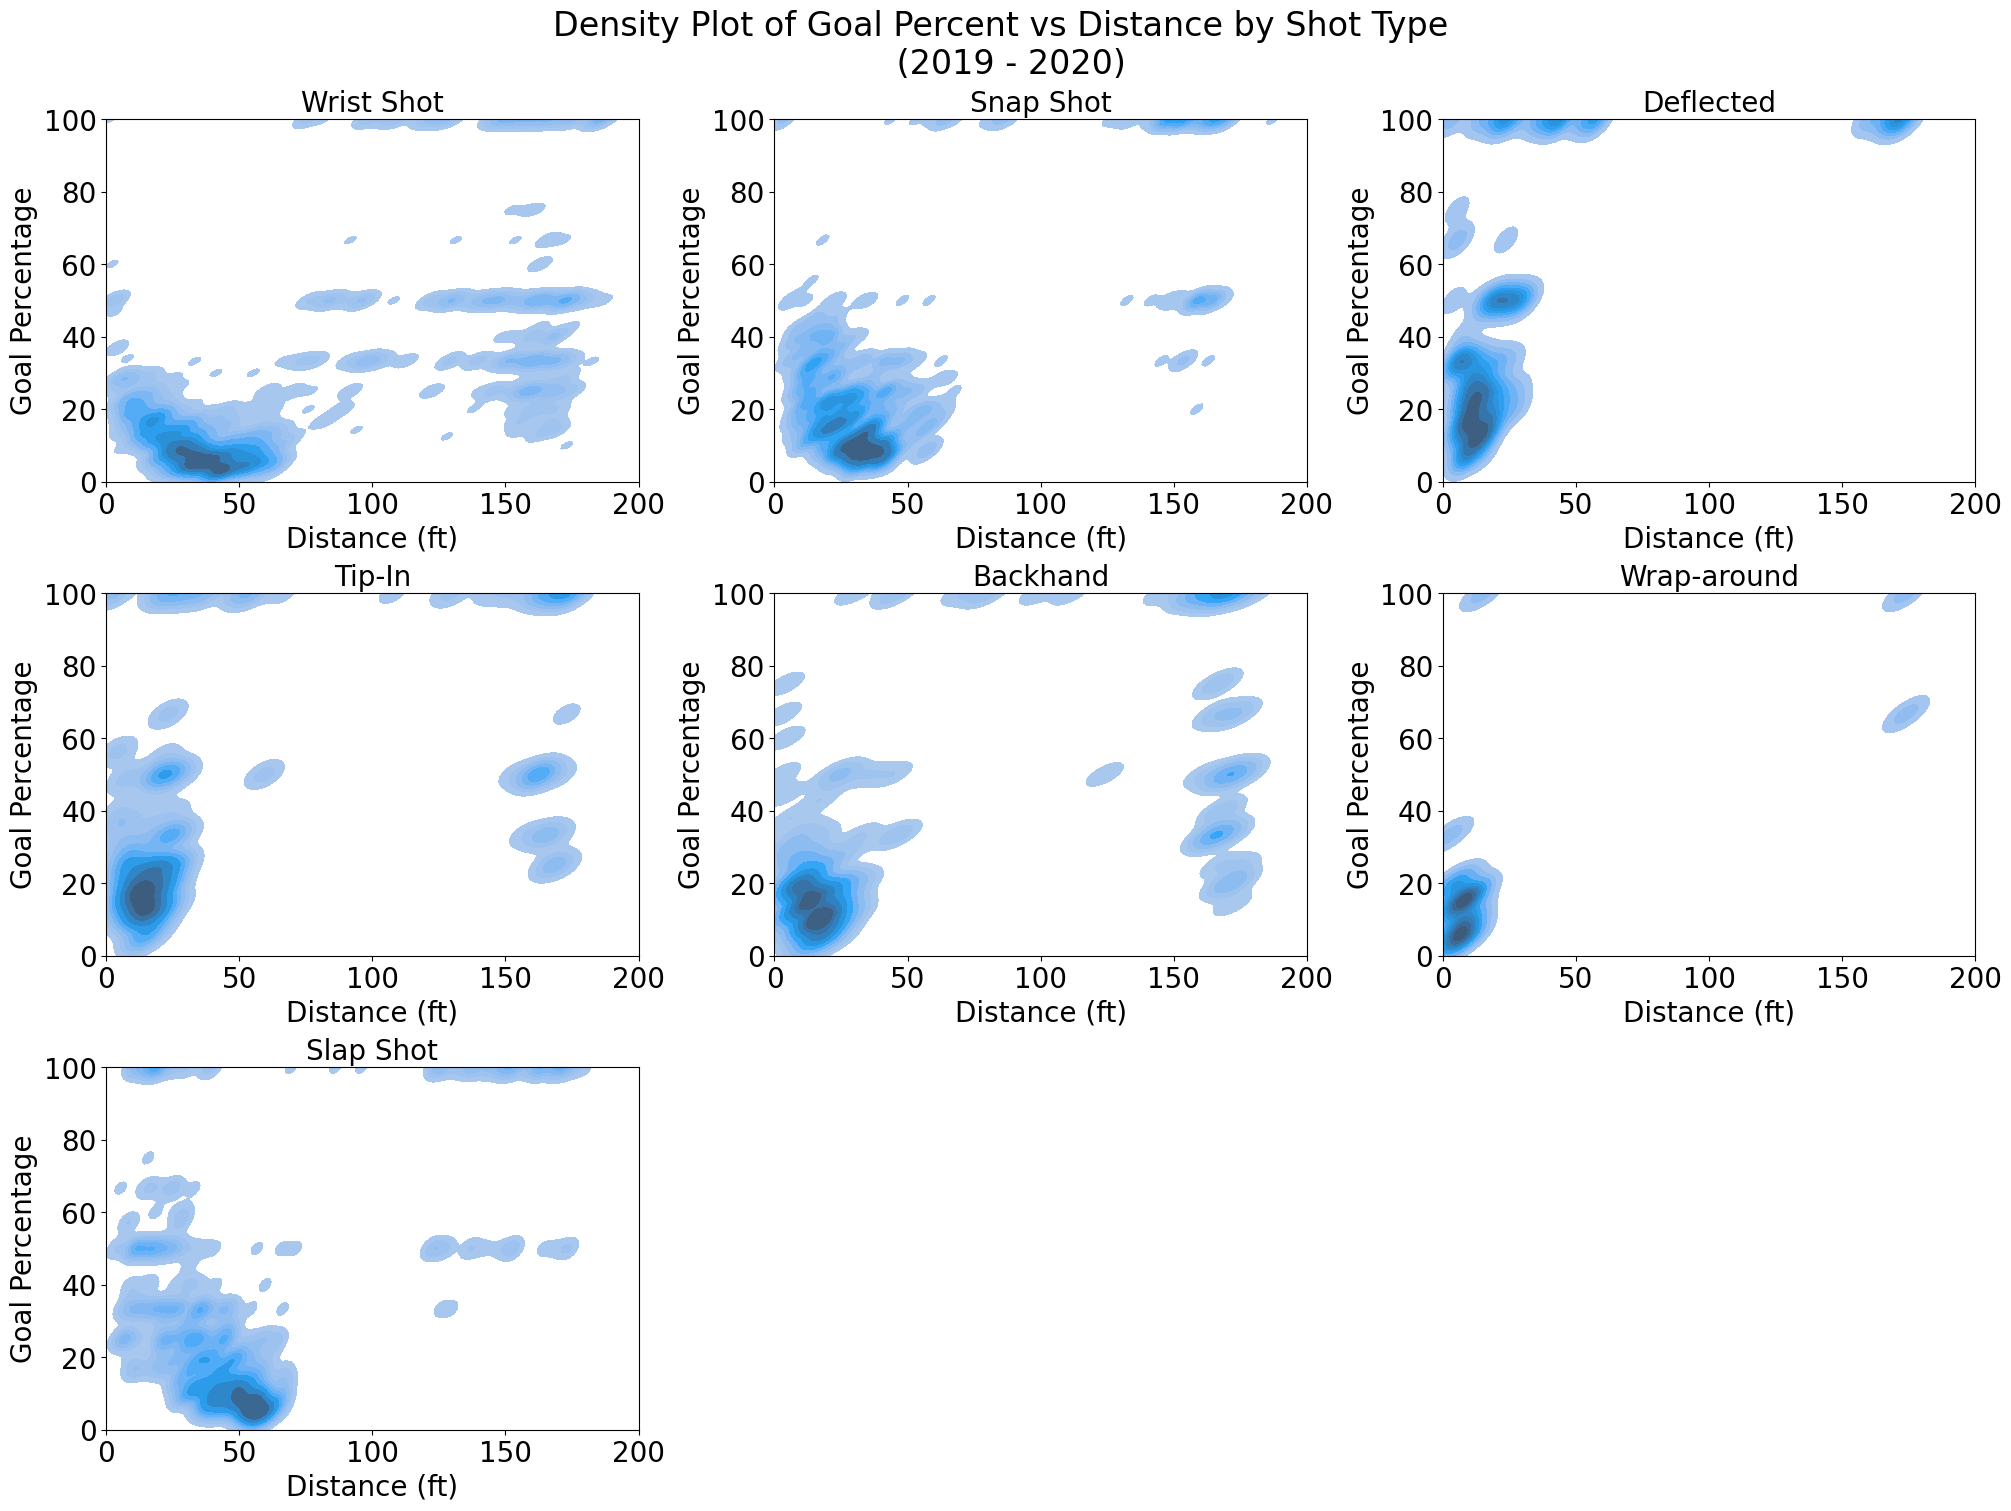

In [14]:
distance_vs_goal_percent_vs_shot_types_kdeplot(2019)

In [15]:
def distance_vs_goal_percent_vs_shot_types_violinplot(season):
    df_season = df[df['season'] == season].reset_index()
    
    fig, ax = plt.subplots(figsize=(10,6.5))
    plt.axis('on')

    ax = sns.violinplot(x="shotType", y="distance", hue="eventType",
                data=df_season, palette="viridis", split=True)
    plt.title(f'Violin Plot of Shots vs Goals by Shot Type and Distance from Net \n ({season} - {season+1})')
    plt.xlabel('Shot Type')
    plt.ylabel('Distance (ft)')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                     ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.legend(fontsize=12)

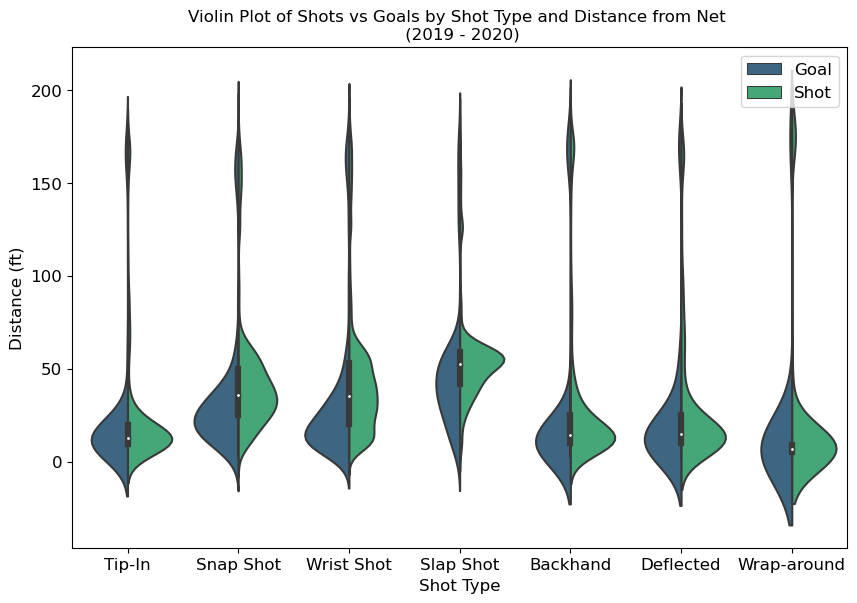

In [16]:
distance_vs_goal_percent_vs_shot_types_violinplot(2019)